In [1]:
require(cowplot)
require(data.table)
require(ggplot2)
require(pbapply)
suppressPackageStartupMessages(require(plotly))
require(viridis)
pboptions(type="timer")

source("../manuscript/functions/save_and_plot.R")

Loading required package: cowplot

Loading required package: data.table

Loading required package: ggplot2

Loading required package: pbapply

Loading required package: viridis

Loading required package: viridisLite



In [2]:
root_path = "../data/3D_David/"
#list.files(file.path(root_path))
#list.files(file.path(root_path, "DW_models"))

In [3]:
probe_meta = fread(file.path(root_path, "probes_chrX46.csv"))
#head(probe_meta)

hic_matrix = fread(file.path(root_path, "mat_hic_46plex.csv"))
#hic_matrix[1:5, 1:5]

In [4]:
hic_data = as.data.table(expand.grid(1:45, 1:45))
setnames(hic_data, LETTERS[1:2])

In [5]:
hic_data$hic_freq = as.matrix(hic_matrix)[as.matrix(hic_data[, .(A, B)])]

In [6]:
coords_dw = rbindlist(pblapply(0:195, function(file_id) {
    coords = fread(file.path(root_path, "DW_models", sprintf("model.%d.xyz", file_id)), skip=1, col.names=c("i", "region", "x", "y", "z"), header=F)
    coords$interpolated = c(fread(file.path(root_path, "DW_models", sprintf("model.%d.interpolation", file_id)), header=F)) == 0
    coords[, chrom := gsub("(chr[0-9X]+):([0-9]+)-([0-9]+)", "\\1", region)]
    coords[, start := as.numeric(gsub("(chr[0-9X]+):([0-9]+)-([0-9]+)", "\\2", region))]
    coords[, end := as.numeric(gsub("(chr[0-9X]+):([0-9]+)-([0-9]+)", "\\3", region))]
    coords[, file_id := file_id+1]
    return(coords)
}, cl=1))

coords_rl = rbindlist(pblapply(0:175, function(file_id) {
    coords = fread(file.path(root_path, "RL_models", sprintf("model.%d.xyz", file_id)), skip=1, col.names=c("i", "region", "x", "y", "z"), header=F)
    coords$interpolated = c(fread(file.path(root_path, "RL_models", sprintf("model.%d.interpolation", file_id)), header=F)) == 0
    coords[, chrom := gsub("(chr[0-9X]+):([0-9]+)-([0-9]+)", "\\1", region)]
    coords[, start := as.numeric(gsub("(chr[0-9X]+):([0-9]+)-([0-9]+)", "\\2", region))]
    coords[, end := as.numeric(gsub("(chr[0-9X]+):([0-9]+)-([0-9]+)", "\\3", region))]
    coords[, file_id := file_id+1]
    return(coords)
}, cl=1))

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01s  
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01s  


In [7]:
smatch = fread("../data/3D_David/link_rois_RL_DW.csv")
match_vector = smatch[, .(id_DW, id_RL)]
dim(match_vector)

[1] 162   2

In [8]:
print(sprintf("Number of locations in DW: %d", coords_dw[, .N, by=file_id][, unique(N)]))
print(sprintf("Number of DW structures: %d", coords_dw[, .N, by=region][, unique(N)]))

print(sprintf("Number of locations in RL: %d", coords_rl[, .N, by=file_id][, unique(N)]))
print(sprintf("Number of RL structures: %d", coords_rl[, .N, by=region][, unique(N)]))

[1] "Number of locations in DW: 46"
[1] "Number of DW structures: 196"
[1] "Number of locations in RL: 46"
[1] "Number of RL structures: 176"


In [9]:
coords_dw[, .N, by=interpolated]
coords_rl[, .N, by=interpolated]

interpolated,N
<lgl>,<int>
FALSE,8688
TRUE,328


interpolated,N
<lgl>,<int>
FALSE,6033
TRUE,2063


In [10]:
hic_data_dw = rbindlist(pblapply(1:196, function(current_file_id) {
    hic_data2 = copy(hic_data)
    hic_data2$A_interpolated = coords_dw[file_id == current_file_id, interpolated][hic_data$A]
    hic_data2$B_interpolated = coords_dw[file_id == current_file_id, interpolated][hic_data$B]
    hic_data2$dist3d = as.matrix(dist(coords_dw[file_id == current_file_id, .(x, y, z)]))[as.matrix(hic_data[, .(A, B)])]
    hic_data2$file_id = current_file_id
    return(hic_data2)
}))
hic_data_dw[, method := "DW"]

hic_data_rl = rbindlist(pblapply(1:176, function(current_file_id) {
    hic_data2 = copy(hic_data)
    hic_data2$A_interpolated = coords_rl[file_id == current_file_id, interpolated][hic_data$A]
    hic_data2$B_interpolated = coords_rl[file_id == current_file_id, interpolated][hic_data$B]
    hic_data2$dist3d = as.matrix(dist(coords_rl[file_id == current_file_id, .(x, y, z)]))[as.matrix(hic_data[, .(A, B)])]
    hic_data2$file_id = current_file_id
    return(hic_data2)
}))
hic_data_rl[, method := "RL"]

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01s  
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01s  


In [11]:
pdata = rbindlist(list(hic_data_dw, hic_data_rl))
pdata_noInterp = pdata[!A_interpolated & !B_interpolated]

## Probe statistics

In [12]:
probe_meta[, summary(Length)]

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 253654  356775  427788  445456  497240 1228151 

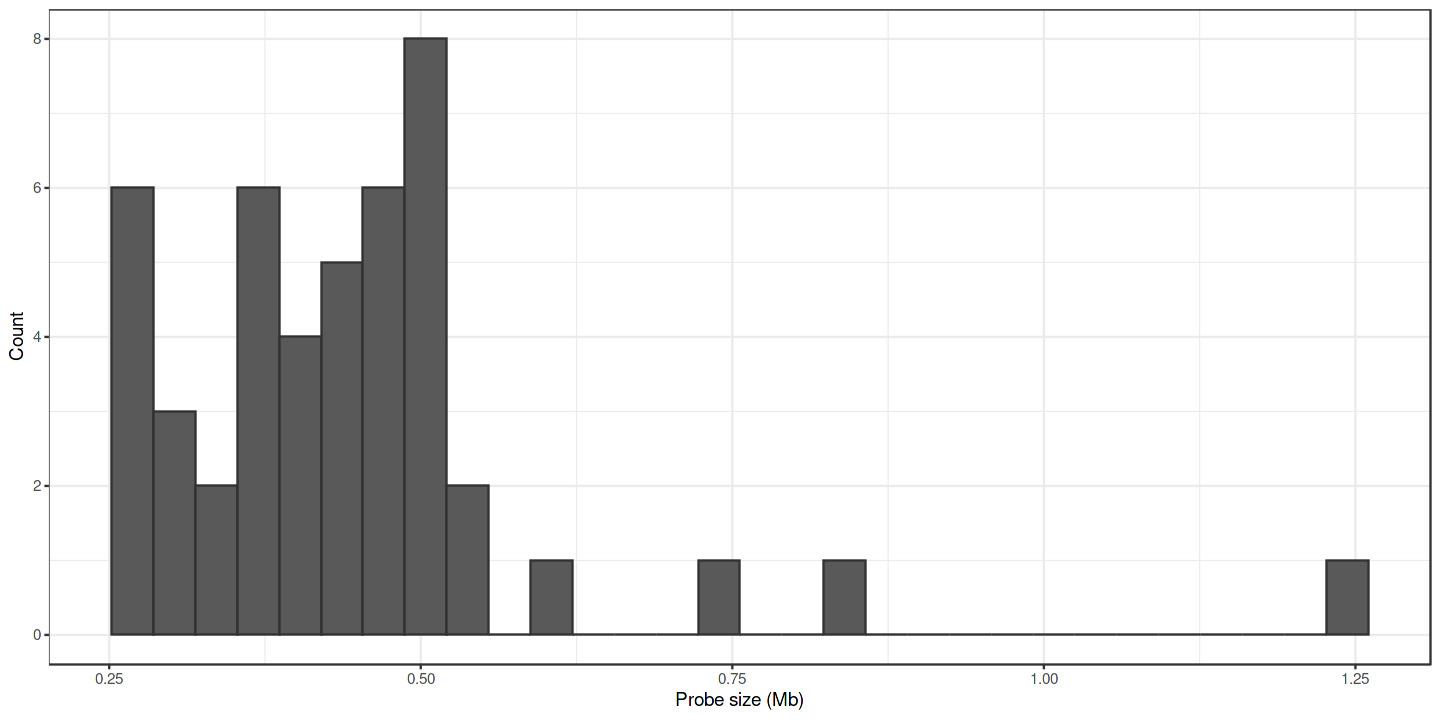

In [13]:
options(repr.plot.width=12, repr.plot.height=6)
ggplot(probe_meta, aes(Length/1e6)) + geom_histogram(color="#323232", bins=30) +
    theme_bw() + labs(x="Probe size (Mb)", y="Count")

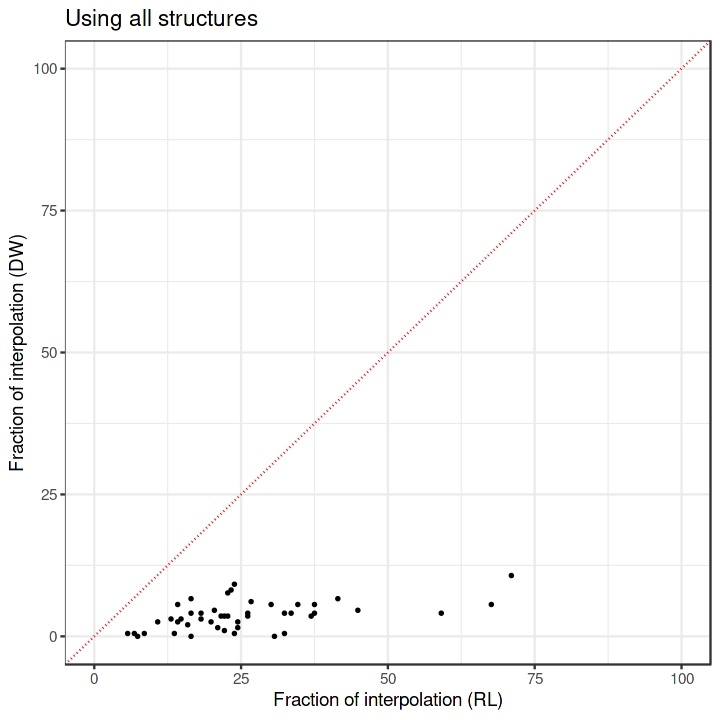

In [14]:
finterp_rl = coords_rl[, .(RL=sum(interpolated)/.N), by=i]
setkeyv(finterp_rl, "i")
finterp_dw = coords_dw[, .(DW=sum(interpolated)/.N), by=i]
setkeyv(finterp_dw, "i")
finterp = merge(finterp_rl, finterp_dw)

options(repr.plot.width=6, repr.plot.height=6)
ggplot(finterp, aes(RL*100, DW*100)) +
    geom_abline(slope=1, color="red", linetype="dotted") +
    geom_point(size=.5) + theme_bw() + xlim(0,100) + ylim(0,100) +
    labs(x="Fraction of interpolation (RL)", y="Fraction of interpolation (DW)", title="Using all structures")

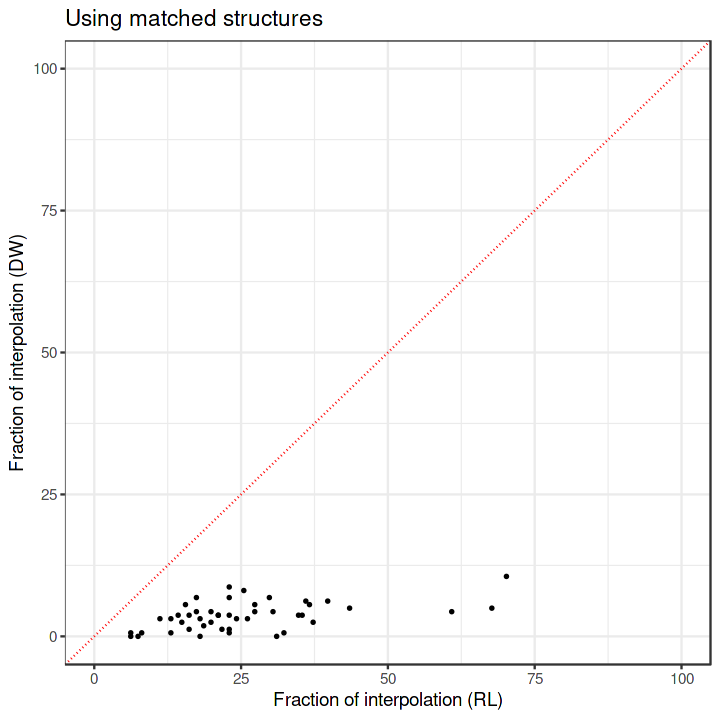

In [15]:
finterp_rl = coords_rl[file_id %in% match_vector$id_RL, .(RL=sum(interpolated)/.N), by=i]
setkeyv(finterp_rl, "i")
finterp_dw = coords_dw[file_id %in% match_vector$id_DW, .(DW=sum(interpolated)/.N), by=i]
setkeyv(finterp_dw, "i")
finterp = merge(finterp_rl, finterp_dw)

options(repr.plot.width=6, repr.plot.height=6)
ggplot(finterp, aes(RL*100, DW*100)) +
    geom_abline(slope=1, color="red", linetype="dotted") +
    geom_point(size=.5) + theme_bw() + xlim(0,100) + ylim(0,100) +
    labs(x="Fraction of interpolation (RL)", y="Fraction of interpolation (DW)", title="Using matched structures")

In [16]:
p = ggplot(finterp, aes((1-RL)*100, (1-DW)*100)) +
    geom_abline(slope=1, color="red", linetype="dotted") +
    geom_point(size=.5) + theme_bw() + xlim(20,100) + ylim(20,100) +
    labs(x="Detection efficiency (RL)", y="Detection efficiency (DW)",
         title="Probe detection efficiency", subtitle="From 162 matched structures")
save_and_plot(p, "plots/probe_detection_efficiency.matched_structures.dw_rl", width=3, height=3, formats=c("png", "jpg", "pdf"))

In [17]:
pdata$dlinear = abs(probe_meta[pdata$A, (Start+End)/2] - probe_meta[pdata$B, (Start+End)/2])
pdata_noInterp$dlinear = abs(probe_meta[pdata_noInterp$A, (Start+End)/2] - probe_meta[pdata_noInterp$B, (Start+End)/2])

In [18]:
pdata[, .(.N, mean(dist3d), mean(dlinear)), by=c("A_interpolated", "B_interpolated")]

A_interpolated,B_interpolated,N,V2,V3
<lgl>,<lgl>,<int>,<dbl>,<dbl>
FALSE,FALSE,569707,2.033919,50365481
TRUE,FALSE,78428,1.826447,51220312
FALSE,TRUE,78428,1.826447,51220312
TRUE,TRUE,26737,1.448170,46486430


# Average distance

In [19]:
ppdata0 = pdata[, .(hic_freq=hic_freq[1], dlinear=dlinear[1], mean_dist3d=mean(dist3d)), by=c("A", "B", "method")]
ppdata = pdata_noInterp[, .(hic_freq=hic_freq[1], dlinear=dlinear[1], mean_dist3d=mean(dist3d)), by=c("A", "B", "method")]
#head(ppdata)

## Hi-C frequency versus average distance from OligoFISSEQ

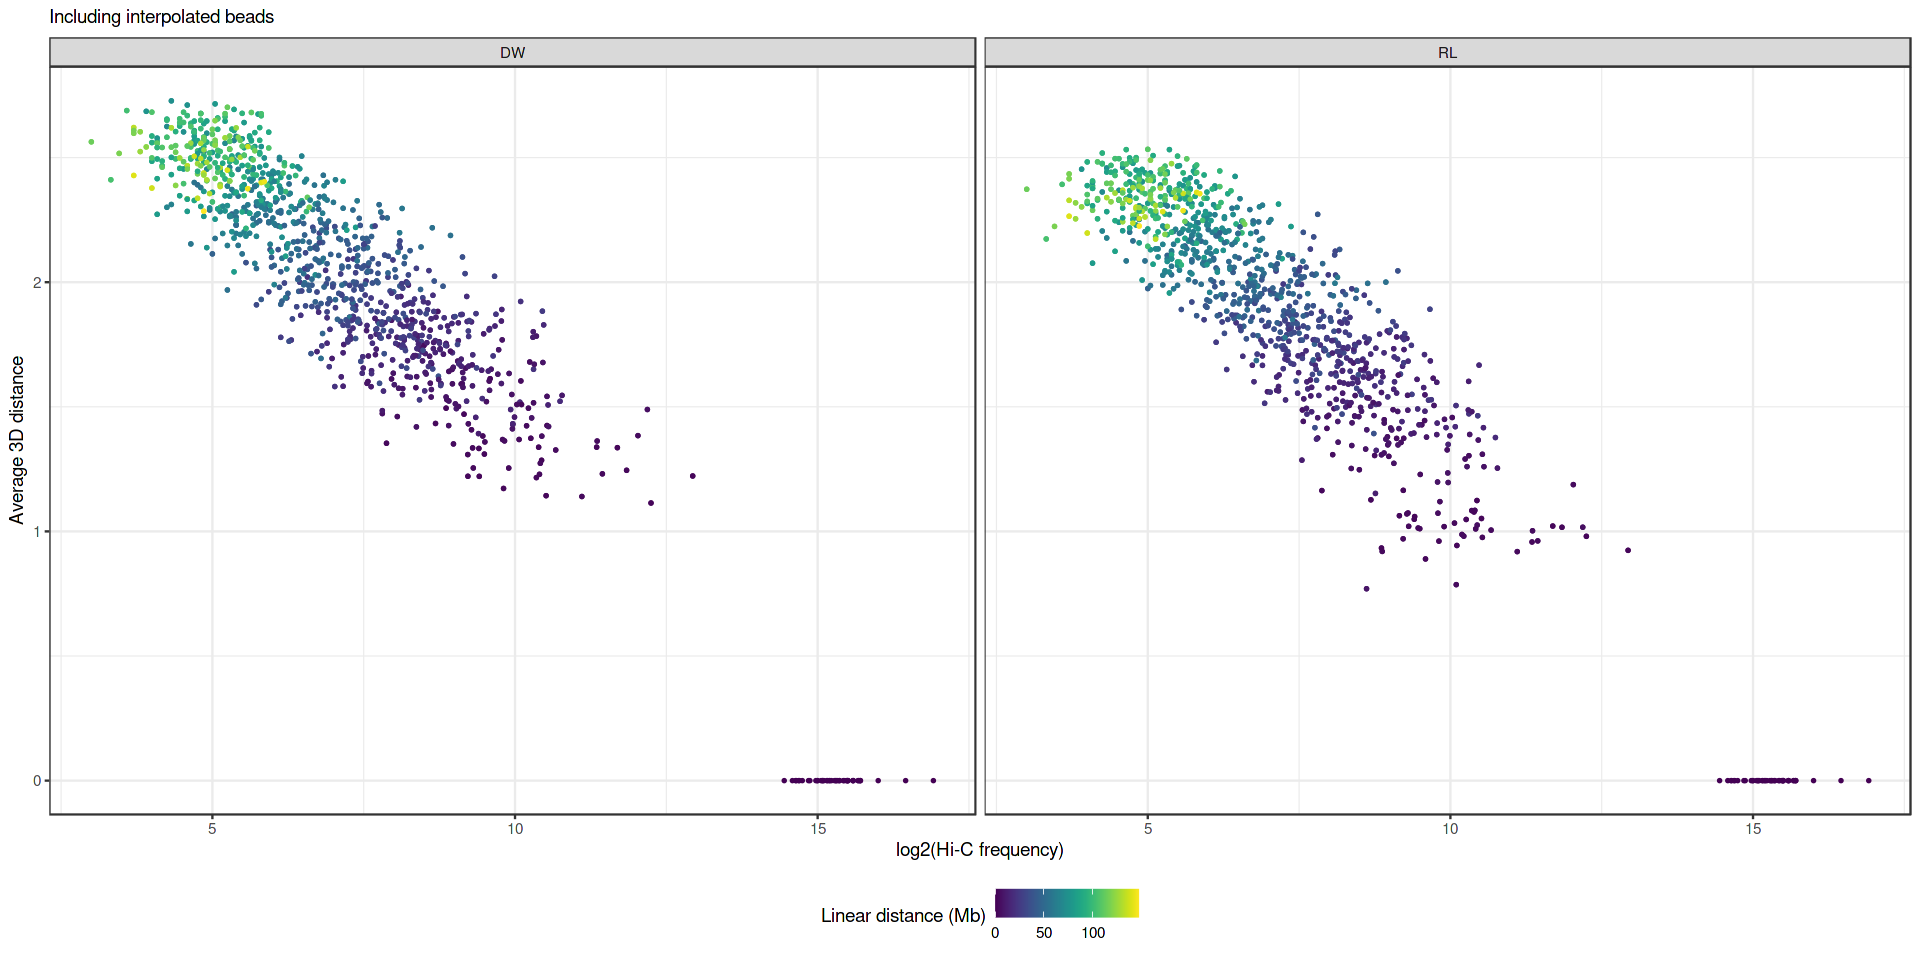

In [20]:
options(repr.plot.width=16, repr.plot.height=8)
ggplot(ppdata0, aes(hic_freq, mean_dist3d, color=dlinear/1e6)) +
    geom_point(size=.5) + facet_wrap(~method) + theme_bw() +
    labs(x="log2(Hi-C frequency)", y="Average 3D distance", color="Linear distance (Mb)", subtitle="Including interpolated beads") +
    scale_color_viridis() + theme(legend.position="bottom")

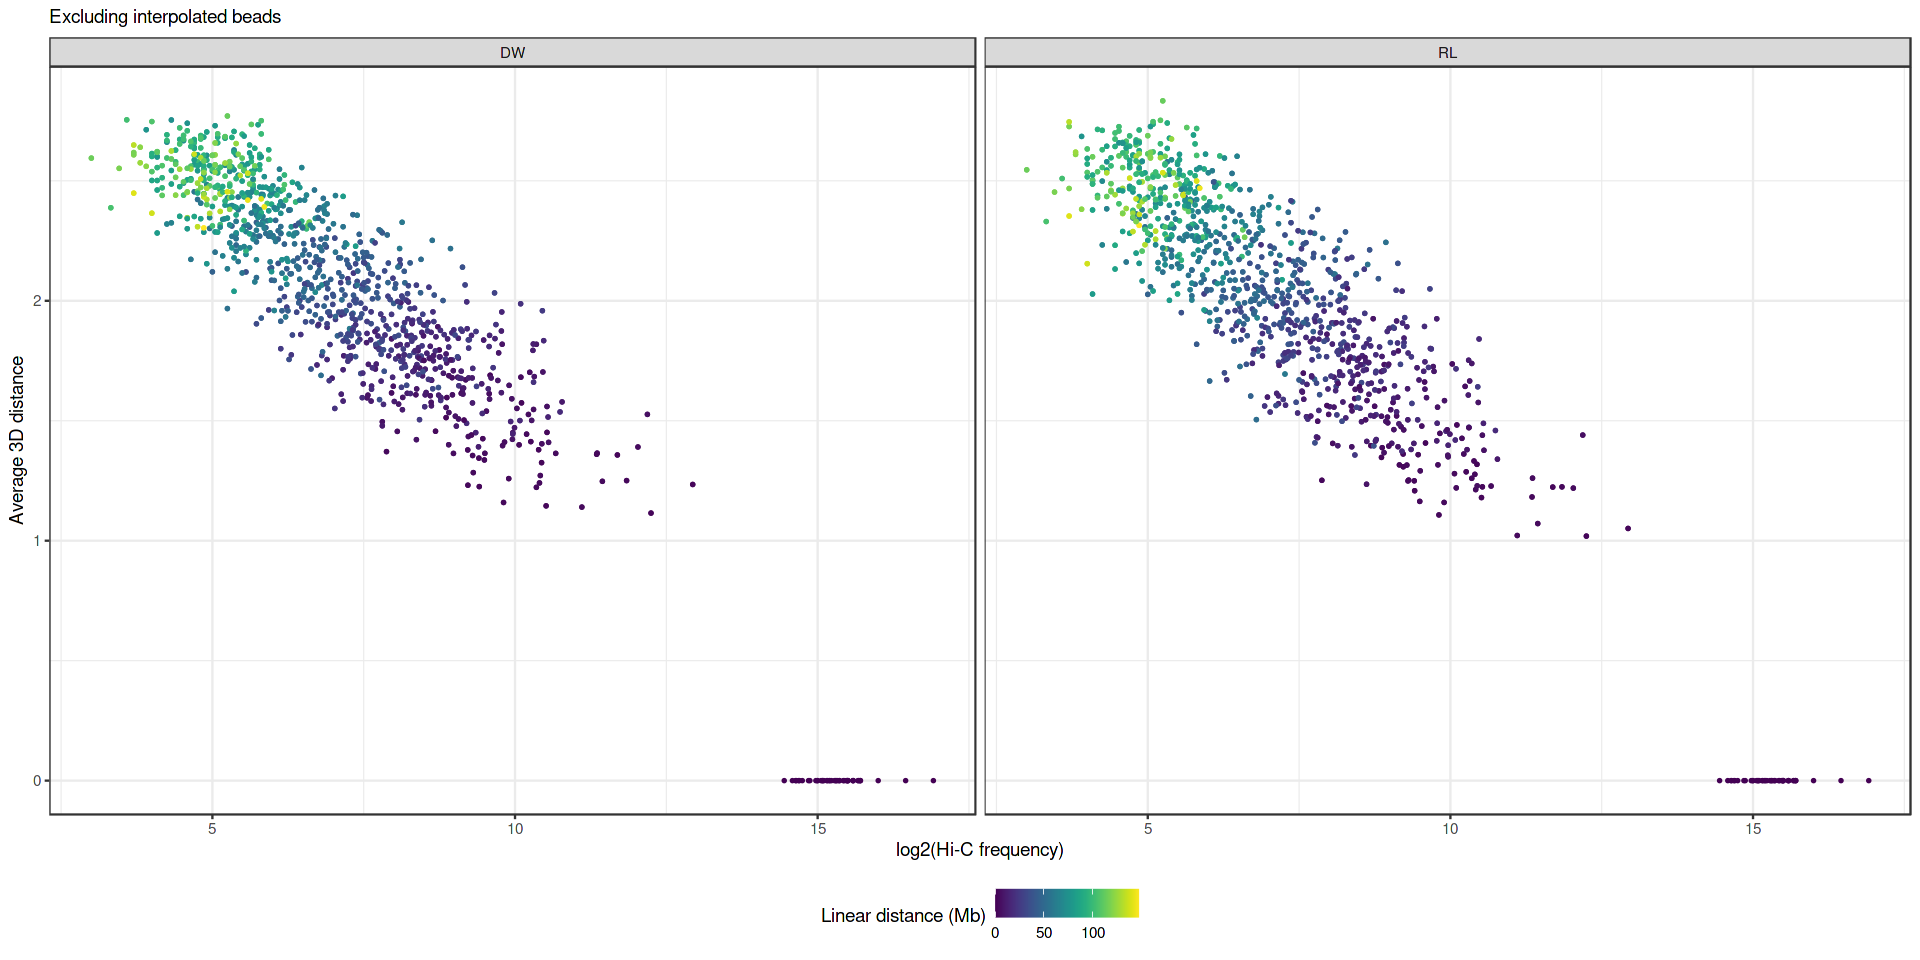

In [21]:
options(repr.plot.width=16, repr.plot.height=8)
ggplot(ppdata, aes(hic_freq, mean_dist3d, color=dlinear/1e6)) +
    geom_point(size=.5) + facet_wrap(~method) + theme_bw() +
    labs(x="log2(Hi-C frequency)", y="Average 3D distance", color="Linear distance (Mb)", subtitle="Excluding interpolated beads") +
    scale_color_viridis() + theme(legend.position="bottom")

## Comparison of average 3D distance from OligoFISSEQ, using DW or RL
Overall, 3D coordinates in DW seem to be more distant, i.e., the chromosome territory has larger volume.

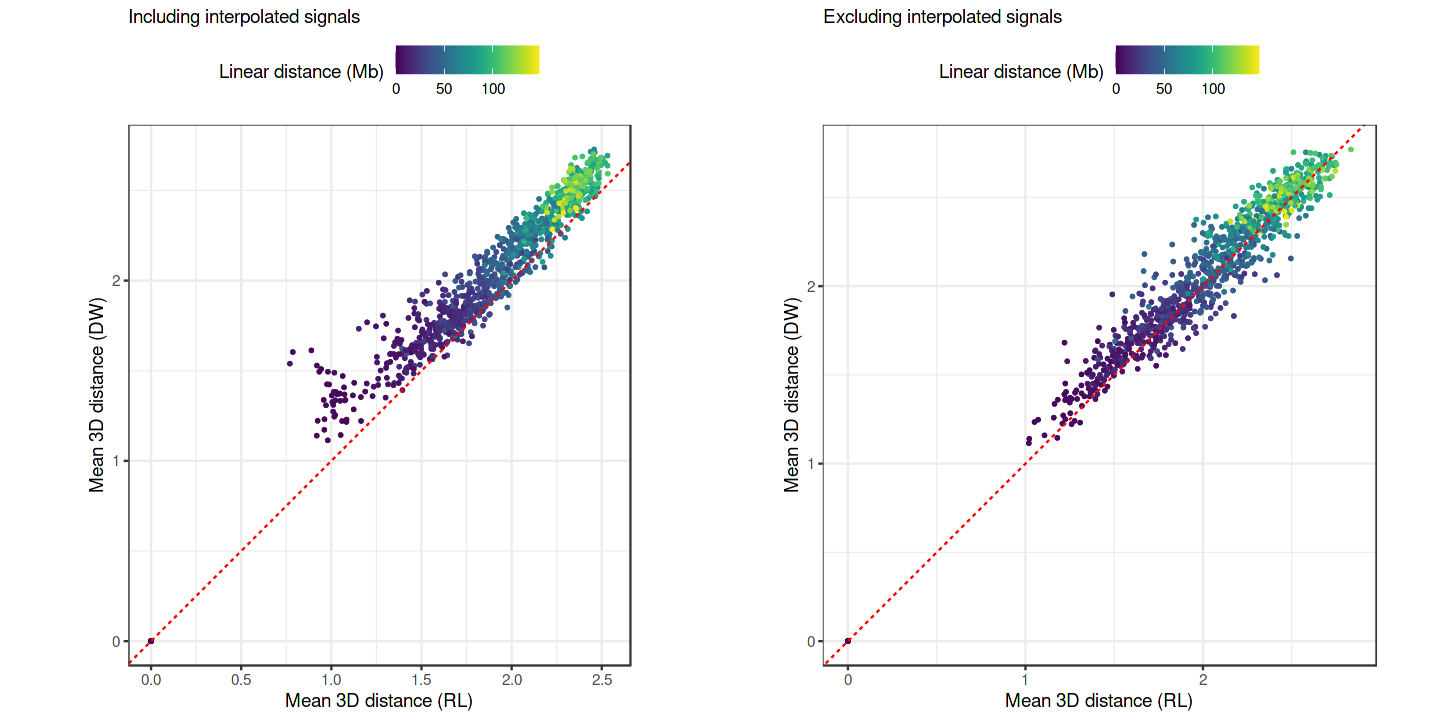

In [22]:
p1=ggplot(dcast(ppdata0, A+B+hic_freq+dlinear~method, value.var="mean_dist3d"), aes(RL, DW, color=dlinear/1e6)) +
    geom_point(size=.5) + geom_abline(slope=1, color="red", linetype="dashed") +
    theme_bw() + labs(x="Mean 3D distance (RL)", y="Mean 3D distance (DW)", color="Linear distance (Mb)", subtitle="Including interpolated signals") +
    scale_color_viridis() + theme(legend.position="top") + coord_fixed()
p2=ggplot(dcast(ppdata, A+B+hic_freq+dlinear~method, value.var="mean_dist3d"), aes(RL, DW, color=dlinear/1e6)) +
    geom_point(size=.5) + geom_abline(slope=1, color="red", linetype="dashed") +
    theme_bw() + labs(x="Mean 3D distance (RL)", y="Mean 3D distance (DW)", color="Linear distance (Mb)", subtitle="Excluding interpolated signals") +
    scale_color_viridis() + theme(legend.position="top") + coord_fixed()
options(repr.plot.width=12, repr.plot.height=6)
plot_grid(p1, p2, nrow=1)

In [23]:
dcast(ppdata0, A+B+hic_freq+dlinear~method, value.var="mean_dist3d")[, cor(DW, RL, use="pairwise.complete.obs")]
dcast(ppdata, A+B+hic_freq+dlinear~method, value.var="mean_dist3d")[, cor(DW, RL, use="pairwise.complete.obs")]

[1] 0.9736505

[1] 0.9735674